# Baselines and Formulation


## Data Preparation

In [1]:
import json
import zipfile
import os
import pandas as pd
import numpy as np

In [2]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ focal-pgdg main
 * Starting PostgreSQL 11 database server
   ...done.
ALTER ROLE
DROP DATABASE
CREATE DATABASE
env: DEMO_DATABASE_NAME=donors_choose
env: DEMO_DATABASE_HOST=localhost
env: DEMO_DATABASE_PORT=5432
DROP DATABASE
CREATE DATABASE
env: DEMO_DATABASE_NAME=donors_choose
env: DEMO_DATABASE_HOST=localhost
env: DEMO_DATABASE_PORT=5432
env: DEMO_DATABASE_USER=postgres
env: DEMO_DATABASE_PASS=postgres


In [3]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)
full_projects = pd.read_sql("SELECT * FROM data.projects", db_engine)
full_resources = pd.read_sql("SELECT * FROM data.resources", db_engine)
full_donations = pd.read_sql("SELECT * FROM data.donations", db_engine)


full_projects=full_projects.rename(columns = {'projectid_str':'projectid', "total_asking_price":"total_price_excluding_optional_support"})
full_donations = full_donations.rename(columns = {'projectid_str':'projectid'})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json
import zipfile
import os
import pandas as pd

In [5]:
!pip install kaggle

!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
api_token = {"username":"ploped123","key":"eeeeba8fc52706723e4c1bcf41ae6fd3"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c kdd-cup-2014-predicting-excitement-at-donors-choose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
kdd-cup-2014-predicting-excitement-at-donors-choose.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls /content

donations.csv
donations.csv.zip
donors_sampled_20210920_v3.dmp
essays.csv
essays.csv.zip
kdd-cup-2014-predicting-excitement-at-donors-choose.zip
outcomes.csv.zip
projects.csv
projects.csv.zip
resources.csv
resources.csv.zip
sample_data
sampleSubmission.csv.zip


In [ ]:
!unzip /content/kdd-cup-2014-predicting-excitement-at-donors-choose.zip

In [ ]:
!unzip /content/resources.csv.zip
!unzip /content/donations.csv.zip

In [ ]:
!unzip /content/projects.csv.zip

In [7]:
full_donations = pd.read_csv("/content/donations.csv")
full_projects = pd.read_csv("/content/projects.csv")
# full_essays = pd.read_csv("essays.csv")
full_resources = pd.read_csv("/content/resources.csv")

In [8]:
from datetime import timedelta
!pip install textstat
!pip install flair

import textstat

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

import flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Feature Engineering

In [9]:
a = pd.merge(full_projects, full_donations, on=['projectid'], how='left')
a['in_4_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=120)
a['in_1_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=30)
a['donation_1mo'] = a['donation_to_project'].values
values = {'donation_to_project': 0.0}
a = a.fillna(value=values)
a.loc[a['in_4_months'] == False, 'donation_to_project'] = 0.0
a.loc[a['in_1_months'] == False, 'donation_1mo'] = 0.0

donation_in_4_months = a.groupby(['projectid'])['donation_to_project'].sum().reset_index(name='donation_in_4_months')
donation_in_1_months = a.groupby(['projectid'])['donation_1mo'].sum().reset_index(name='donation_in_1_months')
df = pd.merge(full_projects, donation_in_4_months, on=['projectid'], how='left')
df = pd.merge(df, donation_in_1_months, on=['projectid'], how='left')

del a

In [10]:
df['is_fully_funded_after_4_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_4_months']
# df['is_fully_funded_after_4_months'] = df['total_asking_price'] <= df['donation_in_4_months']
df['is_fully_funded_after_4_months'].value_counts()
print("Baserate % projects fully funded:", df['is_fully_funded_after_4_months'].mean())

df['pct_funded_1mo'] = df['donation_in_1_months'] / df['total_price_excluding_optional_support']
df['is_fully_funded_after_1_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_1_months']
#df['is_fully_funded_after_1_months'] = df['total_asking_price'] <= df['donation_in_1_months']
df['is_fully_funded_after_1_months'].value_counts()
print("Baserate % projects fully funded 1mo:", df['is_fully_funded_after_1_months'].mean())

Baserate % projects fully funded: 0.5480215269433126
Baserate % projects fully funded 1mo: 0.30470804007842217


In [11]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['children_helped_per_dollar'] = df['students_reached']/df['total_price_excluding_optional_support']

In [12]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'donation_in_4_months', 'donation_in_1_months',
       'is_fully_funded_after_4_months', 'pct_funded_1mo',
       'is_fully_funded_after_1_months', 'child

In [13]:
df.shape

(664098, 41)

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_feature_cols = ['grade_level', 'teacher_prefix', 'school_state']
df = df.replace({'school_charter': {'t': 1, 'f': 0},
                 'school_kipp': {'t': 1, 'f': 0}})

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding
encoder_df = pd.DataFrame(encoder.fit_transform(df[one_hot_feature_cols]).toarray())
encoder_df.columns = encoder.get_feature_names()
#merge one-hot encoded columns back with original DataFrame
final_X = df.join(encoder_df)
#drop the original columns
final_X = final_X.drop(one_hot_feature_cols, axis=1)

df = final_X

# # row 28-36
feature_cols_projects = ['school_charter', 'school_kipp', 'total_price_excluding_optional_support', 'students_reached', 'teacher_acctid', 'school_city', 'date_posted'] + list(final_X.columns[-50:])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_zip',
       'school_metro', 'school_district',
       ...
       'x2_SD', 'x2_TN', 'x2_TX', 'x2_UT', 'x2_VA', 'x2_VT', 'x2_WA', 'x2_WI',
       'x2_WV', 'x2_WY'],
      dtype='object', length=101)

In [16]:
!unzip /content/essays.csv.zip
full_essays = pd.read_csv("/content/essays.csv")
full_essays.head()

Archive:  /content/essays.csv.zip
replace essays.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


,projectid,teacher_acctid,title,short_description,need_statement,essay
0,ffffc4f85b60efc5b52347df489d0238,c24011b20fc161ed02248e85beb59a90,iMath,It is imperative that teachers bring technolog...,My students need four iPods.,I am a fourth year fifth grade math teacher. T...
1,ffffac55ee02a49d1abc87ba6fc61135,947066d0af47e0566f334566553dd6a6,Recording Rockin' Readers,Can you imagine having to translate everything...,My students need a camcorder.,Can you imagine having to translate everything...
2,ffff97ed93720407d70a2787475932b0,462270f5d5c212162fcab11afa2623cb,Kindergarten In Need of Important Materials!,It takes a special person to donate to a group...,My students need 17 assorted classroom materia...,Hi. I teach a wonderful group of 4-5 year old ...
3,ffff7266778f71242675416e600b94e1,b9a8f14199e0d8109200ece179281f4f,Let's Find Out!,My Kindergarten students come from a variety o...,"My students need 25 copies of Scholastic's ""Le...",My Kindergarten students come from a variety o...
4,ffff418bb42fad24347527ad96100f81,e885fb002a1d0d39aaed9d21a7683549,Whistle While We Work!,"By using the cross curricular games requested,...",My students need grade level appropriate games...,All work and no play makes school a dull place...


In [17]:
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
full_essays.shape

(664098, 6)

In [19]:
sample_essays = full_essays.iloc[:100000]

In [20]:
sample_polarity = sample_essays['title'].astype(str).apply(lambda x: sid.polarity_scores(x))

In [21]:
sample_polarity = sample_essays['short_description'].astype(str).apply(lambda x: sid.polarity_scores(x))

In [22]:
#flair_sentiment= flair.models.TextClassifier.load('en-sentiment')
sid = SentimentIntensityAnalyzer()
for col in ['title','short_description', 'need_statement', 'essay']:
  print(col)
  full_essays[col + '_len'] = full_essays[col].str.len()
  full_essays[col + '_wordlen'] = full_essays[col].astype(str).apply(lambda x: len(x) / len(x.split(' ')))

for col in ['title','short_description']:
  print(col)
  full_essays[col + '_sent'] = full_essays[col].astype(str).apply(lambda x: sid.polarity_scores(x))
  full_essays[col + '_sentnet'] = full_essays[col + '_sent'].apply(lambda x: x['pos'] - x['neg'])
  full_essays[col + '_sentpol'] = full_essays[col + '_sent'].apply(lambda x: x['pos'] + x['neg'])

title
short_description
need_statement
essay
title
short_description


In [23]:
full_essays = full_essays.drop(columns=['teacher_acctid', 'title', 'short_description', 'need_statement', 'essay'])

In [24]:
df = pd.merge(df, full_essays, on=['projectid'], how='left')

In [25]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_zip',
       'school_metro', 'school_district',
       ...
       'need_statement_len', 'need_statement_wordlen', 'essay_len',
       'essay_wordlen', 'title_sent', 'title_sentnet', 'title_sentpol',
       'short_description_sent', 'short_description_sentnet',
       'short_description_sentpol'],
      dtype='object', length=115)

In [26]:
import numpy as np

In [27]:
resource_df = full_resources[['resourceid', 'projectid', 'project_resource_type', 'item_unit_price', 'item_quantity']]
resource_df['project_resource_type'] = resource_df['project_resource_type'].astype('str')

# Fill in missing values of item_unit_price & item_quantity
resource_types = np.unique(resource_df['project_resource_type'].tolist())
avg_unit_price = {}
avg_quantity = {}
for rtype in resource_types:
  avg = resource_df.loc[resource_df['project_resource_type'] == rtype]['item_unit_price'].mean()
  avg_unit_price[rtype] = avg
  avg_num = np.floor(resource_df.loc[resource_df['project_resource_type'] == rtype]['item_quantity'].mean())
  avg_quantity[rtype] = avg_num

resource_df['avg_unit_price'] = resource_df.apply(lambda row: avg_unit_price[row['project_resource_type']], axis=1) # This could take a minute to run
resource_df['avg_quantity'] = resource_df.apply(lambda row: avg_quantity[row['project_resource_type']], axis=1)

resource_df['item_unit_price'] = resource_df['item_unit_price'].fillna(resource_df['avg_unit_price'])
resource_df['item_quantity'] = resource_df['item_quantity'].fillna(resource_df['avg_quantity'])

resource_df = resource_df.groupby('projectid').agg({'item_unit_price':'mean', 'item_quantity':'sum'}).reset_index().rename(columns={'item_unit_price':'avg_unit_price', 'item_quantity':'total_item_quantity'})
df = df.merge(resource_df, how='left', on='projectid')

<ipython-input-27-4fa936b62856>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resource_df['project_resource_type'] = resource_df['project_resource_type'].astype('str')
<ipython-input-27-4fa936b62856>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resource_df['avg_unit_price'] = resource_df.apply(lambda row: avg_unit_price[row['project_resource_type']], axis=1) # This could take a minute to run
<ipython-input-27-4fa936b62856>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [28]:
resstat_cols = ['students_reached', 'children_helped_per_dollar', 'primary_focus_area', 'resource_type', 'poverty_level']

text_cols = ['title_len', 'title_sentnet', 'title_sentpol', 'short_description_len', 'short_description_sentnet', 'short_description_sentpol','essay_len', 'need_statement_len']
res_cols = ['avg_unit_price', 'total_item_quantity']
don_cols = ['pct_funded_1mo']
features = resstat_cols + text_cols + res_cols + don_cols + feature_cols_projects + ['projectid']
Y = ['is_fully_funded_after_4_months']
print()
df_final = df[features + Y]

# Silences a warning that doesn't affect anything
pd.options.mode.chained_assignment = None

for i in ['primary_focus_area', 'resource_type', 'poverty_level']:
  new_addition = pd.get_dummies(df_final[i])
  new_addition.columns = [i + ":" + x.replace(" ","_") for x in new_addition.columns]
  for col_name in new_addition.columns:
    df_final[col_name] = new_addition[col_name].copy(deep=True)
df_final.drop(columns = ['primary_focus_area', 'resource_type', 'poverty_level'], inplace=True)
print(df_final.columns)


Index(['students_reached', 'children_helped_per_dollar', 'title_len',
       'title_sentnet', 'title_sentpol', 'short_description_len',
       'short_description_sentnet', 'short_description_sentpol', 'essay_len',
       'need_statement_len', 'avg_unit_price', 'total_item_quantity',
       'pct_funded_1mo', 'school_charter', 'school_kipp',
       'total_price_excluding_optional_support', 'students_reached',
       'teacher_acctid', 'school_city', 'date_posted', 'x2_AR', 'x2_AZ',
       'x2_CA', 'x2_CO', 'x2_CT', 'x2_DC', 'x2_DE', 'x2_FL', 'x2_GA', 'x2_HI',
       'x2_IA', 'x2_ID', 'x2_IL', 'x2_IN', 'x2_KS', 'x2_KY', 'x2_LA', 'x2_La',
       'x2_MA', 'x2_MD', 'x2_ME', 'x2_MI', 'x2_MN', 'x2_MO', 'x2_MS', 'x2_MT',
       'x2_NC', 'x2_ND', 'x2_NE', 'x2_NH', 'x2_NJ', 'x2_NM', 'x2_NV', 'x2_NY',
       'x2_OH', 'x2_OK', 'x2_OR', 'x2_PA', 'x2_RI', 'x2_SC', 'x2_SD', 'x2_TN',
       'x2_TX', 'x2_UT', 'x2_VA', 'x2_VT', 'x2_WA', 'x2_WI', 'x2_WV', 'x2_WY',
       'projectid', 'is_fully_funded_afte

In [29]:
from datetime import datetime

In [30]:
from dateutil.relativedelta import relativedelta

In [31]:
def chron_split_date_ranges(dates, train_length = relativedelta(years=1), val_length = relativedelta(months=1), retrain_length = relativedelta(weeks=2), min_f_col = relativedelta(months=1), min_l_col = relativedelta(months=4)):
  sorted = dates.sort_values()
  first_date = sorted.iloc[0]
  last_date = sorted.iloc[-1]

  split_dates = []

  curr = first_date

  while curr + val_length + train_length + 2 * min_l_col + 2 * min_f_col < last_date:
    train_start = curr + min_f_col
    val_start = train_start + train_length + min_l_col + min_f_col
    
    split_dates.append({
        "train_feature_collection": (curr, train_start),
        "train": (train_start, train_start + train_length),
        "train_label_buffer": (train_start + train_length, train_start + train_length + min_l_col),
        "val_feature_collection": (train_start + train_length + min_l_col, val_start),
        "val": (val_start , val_start + val_length),
        "val_label_buffer": (val_start + val_length, val_start + val_length + min_l_col),
        "train_label": (train_start + min_l_col, train_start + train_length + min_l_col),
        "val_label": (val_start + min_l_col, val_start + val_length + min_l_col)
    })

    curr += retrain_length
  return split_dates

In [58]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-1] # latest split

In [59]:
split

{'train_feature_collection': (Timestamp('2012-06-08 00:00:00'),
  Timestamp('2012-07-08 00:00:00')),
 'train': (Timestamp('2012-07-08 00:00:00'), Timestamp('2013-07-08 00:00:00')),
 'train_label_buffer': (Timestamp('2013-07-08 00:00:00'),
  Timestamp('2013-11-08 00:00:00')),
 'val_feature_collection': (Timestamp('2013-11-08 00:00:00'),
  Timestamp('2013-12-08 00:00:00')),
 'val': (Timestamp('2013-12-08 00:00:00'), Timestamp('2014-01-08 00:00:00')),
 'val_label_buffer': (Timestamp('2014-01-08 00:00:00'),
  Timestamp('2014-05-08 00:00:00')),
 'train_label': (Timestamp('2012-11-08 00:00:00'),
  Timestamp('2013-11-08 00:00:00')),
 'val_label': (Timestamp('2014-04-08 00:00:00'),
  Timestamp('2014-05-08 00:00:00'))}

In [60]:
split["train"][0]

Timestamp('2012-07-08 00:00:00')

In [61]:

# compute success rate grouped by 'feature', only use historical data
def compute_success_rate_by_feature(data, date, feature_names):
  data_before_date = df_final[df_final['date_posted'] < (date - timedelta(days=120))]
  for feature_name in feature_names:
    num_of_success = dict(data_before_date.groupby([feature_name])['is_fully_funded_after_4_months'].sum())
    num_of_projects = dict(data_before_date.groupby([feature_name]).size())
    data['num_of_success_projects_' + feature_name]= data[feature_name].map(num_of_success)
    data['num_of_projects_' + feature_name]= data[feature_name].map(num_of_projects)
    data['success_rate_' + feature_name]= data['num_of_success_projects_' + feature_name] / data['num_of_projects_' + feature_name]
    #drop 'school city'
  data = data.drop(feature_names + ['projectid', 'date_posted'], axis=1)
  data = data.fillna(0)

  return data

def generate_train_val(df, split):
  train = df.loc[(split["train"][0] <= df['date_posted']) & (df['date_posted'] < split["train"][1])].fillna(0)
  train = compute_success_rate_by_feature(train, split["train"][0], ['school_city', 'teacher_acctid'])

  val = df.loc[(split["val"][0] <= df['date_posted']) & (df['date_posted'] < split["val"][1])].fillna(0)
  val = compute_success_rate_by_feature(val, split["train"][0], ['school_city', 'teacher_acctid'])
  return pd.DataFrame(train), pd.DataFrame(val)


In [62]:
train, val = generate_train_val(df_final, split)

In [63]:
train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index()
train_Y = train['is_fully_funded_after_4_months'].values
val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index()
val_Y = val['is_fully_funded_after_4_months'].values

In [64]:
print(val_X.columns)

Index(['index', 'students_reached', 'children_helped_per_dollar', 'title_len',
       'title_sentnet', 'title_sentpol', 'short_description_len',
       'short_description_sentnet', 'short_description_sentpol', 'essay_len',
       'need_statement_len', 'avg_unit_price', 'total_item_quantity',
       'pct_funded_1mo', 'school_charter', 'school_kipp',
       'total_price_excluding_optional_support', 'students_reached', 'x2_AR',
       'x2_AZ', 'x2_CA', 'x2_CO', 'x2_CT', 'x2_DC', 'x2_DE', 'x2_FL', 'x2_GA',
       'x2_HI', 'x2_IA', 'x2_ID', 'x2_IL', 'x2_IN', 'x2_KS', 'x2_KY', 'x2_LA',
       'x2_La', 'x2_MA', 'x2_MD', 'x2_ME', 'x2_MI', 'x2_MN', 'x2_MO', 'x2_MS',
       'x2_MT', 'x2_NC', 'x2_ND', 'x2_NE', 'x2_NH', 'x2_NJ', 'x2_NM', 'x2_NV',
       'x2_NY', 'x2_OH', 'x2_OK', 'x2_OR', 'x2_PA', 'x2_RI', 'x2_SC', 'x2_SD',
       'x2_TN', 'x2_TX', 'x2_UT', 'x2_VA', 'x2_VT', 'x2_WA', 'x2_WI', 'x2_WV',
       'x2_WY', 'primary_focus_area:Applied_Learning',
       'primary_focus_area:Health_&_Sports

# ML models

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
import time

grid search feature selection

In [ ]:
max_res = 0
feature_selected = None
for i in train_X.columns[1:]:
  selected = ["pct_funded_1mo", "children_helped_per_dollar"]
  selected.append(i)
  #print(selected) 
  #print(train_X[selected])
  start = time.time()
  logmodel = LogisticRegression(penalty='none', max_iter=100000000)
  logmodel.fit(train_X[selected], train_Y)
  train_pred = logmodel.predict_proba(train_X[selected])
  val_pred = logmodel.predict_proba(val_X[selected]) # f(x)
  res = logmodel.predict(val_X[selected]) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  for threshold in np.linspace(0.01, 1, 100):
      precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
      precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
      recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
      recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
      results.append([precision_train, recall_train, precision_val, recall_val])
  results = np.array(results)
  #print(results[9, 2]) 
  if max_res < results[9, 2]:
    max_res = results[9, 2]
    feature_selected = selected
print(max_res, feature_selected)

1.0 ['pct_funded_1mo', 'children_helped_per_dollar', 'poverty_level:moderate_poverty']


most recent PR-K graphs

In [ ]:
selected = feature_selected
start = time.time()
logmodel = LogisticRegression(penalty='none', max_iter=100000000)
logmodel.fit(train_X[selected], train_Y)
runtime = time.time() - start
print(runtime)

0.31787848472595215


In [ ]:
#print(val_X)

In [ ]:
train_pred = logmodel.predict_proba(train_X[selected])
val_pred = logmodel.predict_proba(val_X[selected]) # f(x)
res = logmodel.predict(val_X[selected]) # f(x)>0.5

In [ ]:
print(val_pred[:,1])

[0.32004793 0.0397341  0.0641692  ... 0.99534132 0.96508508 0.01896311]


In [ ]:
print(res)

[False False False ...  True  True False]


In [ ]:
train_rank = np.argsort(train_pred[:,1])
val_rank = np.argsort(val_pred[:,1])

In [ ]:
results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])  # 0.683 for l2

1.0


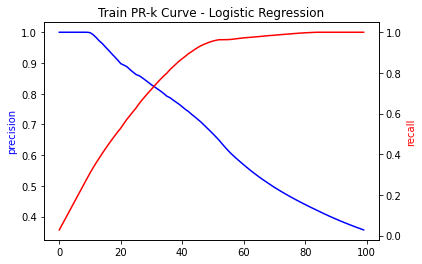

In [ ]:
import matplotlib.pyplot as plt

ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Logistic Regression")
plt.xlabel("Percentage of population selected")
plt.show()

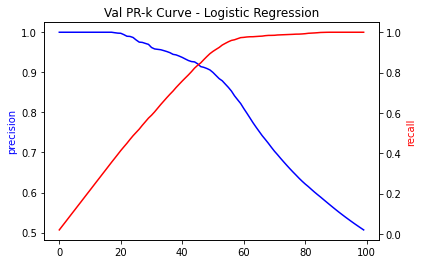

In [ ]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Logistic Regression")
plt.show()

In [ ]:
# train_X.columns[np.argsort(logmodel.feature_importances_)[::-1]]

whole dataset evaluation (precision, recall, tfp)

In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [ ]:
lr_res = []
for s in tqdm(whole_split):
  #print(s)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values
  #curtrain_X.dropna(inplace=True)
  #indices_to_keep = ~curtrain_X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
  #curtrain_X[indices_to_keep].astype(np.float64)
  #curtrain_X.dropna(inplace=True)
  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  logmodel = LogisticRegression(solver = 'saga', penalty='l1', max_iter=100_000)
  logmodel.fit(curtrain_X, curtrain_Y)
  train_pred = logmodel.predict_proba(curtrain_X)
  val_pred = logmodel.predict_proba(curval_X) # f(x)
  res = logmodel.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  threshold = 0.1
  #precision_train = 1 - np.mean(curtrain_Y[train_rank][:int(threshold * len(curtrain_X))])
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  #recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
  #recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
  # results.append([precision_train, recall_train, precision_val, recall_val])
  # results = np.array(results)
  #print(precision_val)  # 0.683 for l2
  lr_res.append(precision_val)
  del logmodel

print(lr_res)

 28%|██▊       | 71/255 [1:45:42<8:45:20, 171.31s/it]

In [ ]:
file1 = open('lr.txt', 'w')
file1.writelines(str(y_value))
file1.close()

## Random Forest PR-k Curves

In [65]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier as rfc
clf = rfc(n_estimators=200)

# Train Decision Tree Classifer
clf = clf.fit(train_X, train_Y)


In [66]:
train_pred = clf.predict_proba(train_X)[:,1]
val_pred = clf.predict_proba(val_X)[:,1]

In [67]:
train_rank = np.argsort(train_pred)
val_rank = np.argsort(val_pred)

results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])

0.9312227074235808


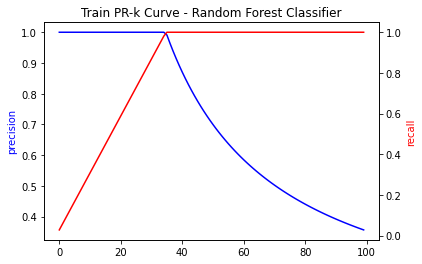

In [68]:
import matplotlib.pyplot as plt
ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Random Forest Classifier")
plt.xlabel("Percentage of population selected")
plt.show()

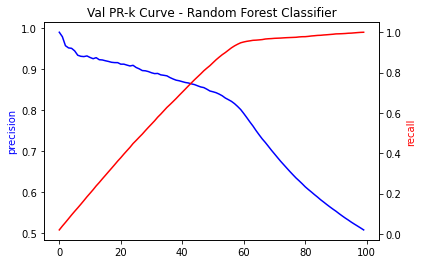

In [69]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Random Forest Classifier")
plt.show()


# XGBoost PR-k Curves

In [70]:
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=100)

#print(train_X.columns[1])
# Train Decision Tree Classifer
if train_X.columns[1] == "students_reached" and val_X.columns[1] == "students_reached":
  train_X = train_X.drop(train_X.columns[1], axis=1)
  val_X = val_X.drop(val_X.columns[1], axis=1)

clf = clf.fit(train_X, train_Y)

In [71]:
train_pred = clf.predict_proba(train_X)[:,1]
val_pred = clf.predict_proba(val_X)[:,1]

In [72]:
train_rank = np.argsort(train_pred)
val_rank = np.argsort(val_pred)

results = []
for threshold in np.linspace(0.01, 1, 100):
    #precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])

0.9563318777292577


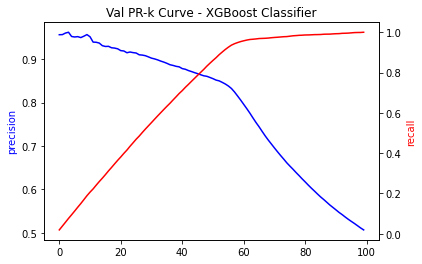

In [73]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - XGBoost Classifier")
plt.show()

# Decision Tree

In [49]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier()


In [43]:
decision_tree_res = []
for s in tqdm(whole_split):
  #print(s)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values
  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  clf = DecisionTreeClassifier(max_depth=25)

  # Train Decision Tree Classifer
  clf = clf.fit(curtrain_X, curtrain_Y)
  train_pred = clf.predict_proba(curtrain_X)
  val_pred = clf.predict_proba(curval_X) # f(x)
  res = clf.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  threshold = 0.1
  #precision_train = 1 - np.mean(curtrain_Y[train_rank][:int(threshold * len(curtrain_X))])
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  #recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
  #recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
  # results.append([precision_train, recall_train, precision_val, recall_val])
  # results = np.array(results)
  decision_tree_res.append(precision_val)
print(decision_tree_res)

100%|██████████| 255/255 [18:16<00:00,  4.30s/it]

[0.25, 0.0625, 0.5277777777777778, 0.4871794871794872, 0.55, 0.6896551724137931, 0.5555555555555556, 0.5833333333333333, 0.6896551724137931, 0.8484848484848485, 0.5625, 0.5714285714285714, 0.56, 0.5238095238095238, 0.39473684210526316, 0.46808510638297873, 0.5490196078431373, 0.5660377358490566, 0.7164179104477613, 0.6612903225806452, 0.6511627906976745, 0.5490196078431373, 0.4482758620689655, 0.4716981132075472, 0.76, 0.7169811320754718, 0.65, 0.7796610169491526, 0.7428571428571429, 0.7457627118644068, 0.7727272727272727, 0.8947368421052632, 0.8095238095238095, 0.9512195121951219, 0.8461538461538461, 0.8695652173913043, 0.7692307692307692, 0.7397260273972603, 0.7522935779816513, 0.7765957446808511, 0.7628865979381443, 0.7647058823529411, 0.8584905660377359, 0.8482142857142857, 0.7142857142857143, 0.7395833333333333, 0.6823529411764706, 0.6346153846153846, 0.717948717948718, 0.7090909090909091, 0.5636363636363637, 0.791044776119403, 0.8461538461538461, 0.9, 0.8881578947368421, 0.872, 0

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [46]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [50]:
rf_res = []
for i, s in enumerate(tqdm(whole_split)):
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values

  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  clf = rfc(n_estimators=200)

  # Train Decision Tree Classifer
  clf = clf.fit(curtrain_X, curtrain_Y)
  train_pred = clf.predict_proba(curtrain_X)
  val_pred = clf.predict_proba(curval_X) # f(x)
  res = clf.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  threshold = 0.1
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  rf_res.append(precision_val)
print(rf_res)

100%|██████████| 255/255 [2:26:15<00:00, 34.41s/it]

[0.33333333333333337, 0.28125, 0.36111111111111116, 0.5384615384615384, 0.55, 0.6896551724137931, 0.7407407407407407, 0.7916666666666666, 0.8620689655172413, 0.7878787878787878, 0.65625, 0.7142857142857143, 0.72, 0.7380952380952381, 0.7631578947368421, 0.6808510638297872, 0.7058823529411764, 0.8490566037735849, 0.8507462686567164, 0.8548387096774194, 0.9069767441860466, 0.7647058823529411, 0.7931034482758621, 0.8679245283018868, 0.94, 0.9433962264150944, 0.95, 0.9830508474576272, 0.9714285714285714, 0.9661016949152542, 1.0, 1.0, 0.9761904761904762, 0.975609756097561, 1.0, 0.9855072463768116, 0.9846153846153847, 0.9863013698630136, 0.9724770642201834, 0.9574468085106383, 0.9587628865979382, 0.9803921568627451, 0.9622641509433962, 1.0, 0.9904761904761905, 1.0, 1.0, 1.0, 0.9914529914529915, 0.990909090909091, 0.990909090909091, 0.9925373134328358, 0.9935897435897436, 1.0, 0.993421052631579, 1.0, 1.0, 1.0, 1.0, 0.9896907216494846, 0.9911504424778761, 1.0, 1.0, 0.990228013029316, 0.98599439

# XGBoost

In [42]:
import xgboost as xgb
from tqdm import tqdm

In [43]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [44]:
xgb_res = []
for i, s in enumerate(tqdm(whole_split)):
  #print(i)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values

  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  clf = xgb.XGBClassifier(n_estimators=50)

  # Train Decision Tree Classifer
  curtrain_X = curtrain_X.drop(curtrain_X.columns[1], axis=1)
  curval_X = curval_X.drop(curval_X.columns[1], axis=1)

  clf = clf.fit(curtrain_X, curtrain_Y)
  train_pred = clf.predict_proba(curtrain_X)
  val_pred = clf.predict_proba(curval_X) # f(x)
  res = clf.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  threshold = 0.1
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  #print(i, precision_val)  # 0.683 for l2
  xgb_res.append(precision_val)

print(xgb_res, np.mean(xgb_res))

100%|██████████| 255/255 [29:16<00:00,  6.89s/it]

[0.25, 0.21875, 0.36111111111111116, 0.5128205128205128, 0.55, 0.7586206896551724, 0.8518518518518519, 0.9166666666666666, 0.9310344827586207, 0.7575757575757576, 0.78125, 0.7142857142857143, 0.6799999999999999, 0.7857142857142857, 0.7631578947368421, 0.7659574468085106, 0.6666666666666667, 0.6226415094339622, 0.7014925373134329, 0.7903225806451613, 0.9069767441860466, 0.9607843137254902, 0.9137931034482758, 0.8679245283018868, 0.96, 0.9811320754716981, 0.9666666666666667, 1.0, 1.0, 1.0, 1.0, 0.9736842105263158, 0.9285714285714286, 0.9512195121951219, 1.0, 0.9855072463768116, 0.9846153846153847, 0.9726027397260274, 0.9541284403669725, 1.0, 1.0, 1.0, 0.9905660377358491, 0.9821428571428571, 0.9904761904761905, 1.0, 1.0, 1.0, 0.9914529914529915, 0.990909090909091, 0.990909090909091, 0.9925373134328358, 1.0, 0.99375, 0.993421052631579, 0.984, 0.990990990990991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.990228013029316, 0.988795518207283, 0.9959349593495935, 0.9958677685950413, 0.9841897233201581, 0.

# Neural Network

In [ ]:
# Import statements
from tqdm import tqdm

In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [ ]:
# Fill in later

129it [32:59, 79.15s/it]

# Commonsense baseline over time - children helped per dollar

In [77]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
baseline_results = []

for split_ in split:
  train, val = generate_train_val(df_final, split_)
  train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  train_Y = train['is_fully_funded_after_4_months'].values
  val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  val_Y = val['is_fully_funded_after_4_months'].values
  train_select = train_X.sort_values(["children_helped_per_dollar"])
  val_select = val_X.sort_values(["children_helped_per_dollar"])
  train_rank = train_select.index.values
  val_rank = val_select.index.values
  threshold = 0.1
  precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
  baseline_results.append(precision_val)

# Base rate over time

In [75]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
base_rate = []

for split_ in split:
  train, val = generate_train_val(df_final, split_)
  train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  train_Y = train['is_fully_funded_after_4_months'].values
  val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  val_Y = val['is_fully_funded_after_4_months'].values
  percentage_not_funded = 1 - val_Y.sum() / len(val_Y)
  base_rate.append(percentage_not_funded)

# Plotting all results over time (logistic regression, nearest neighbor, decision tree, RF, baseline, base rate)

In [80]:
print(baseline_results)

[0.16666666666666663, 0.15625, 0.11111111111111116, 0.2564102564102564, 0.475, 0.5172413793103448, 0.5185185185185186, 0.5, 0.5517241379310345, 0.6363636363636364, 0.5625, 0.6666666666666667, 0.6599999999999999, 0.6190476190476191, 0.5789473684210527, 0.46808510638297873, 0.4117647058823529, 0.4716981132075472, 0.5522388059701493, 0.5483870967741935, 0.5581395348837209, 0.5294117647058824, 0.5517241379310345, 0.49056603773584906, 0.52, 0.6226415094339622, 0.6166666666666667, 0.5423728813559322, 0.5857142857142856, 0.576271186440678, 0.6818181818181819, 0.7105263157894737, 0.8095238095238095, 0.8536585365853658, 0.7948717948717949, 0.8695652173913043, 0.8692307692307693, 0.8424657534246576, 0.7522935779816513, 0.7127659574468085, 0.7525773195876289, 0.7156862745098039, 0.7169811320754718, 0.7053571428571428, 0.6571428571428571, 0.625, 0.7294117647058824, 0.7019230769230769, 0.6837606837606838, 0.7090909090909091, 0.7, 0.6268656716417911, 0.6730769230769231, 0.81875, 0.8092105263157895, 

Text(0, 0.5, 'Precision at Top 10%')

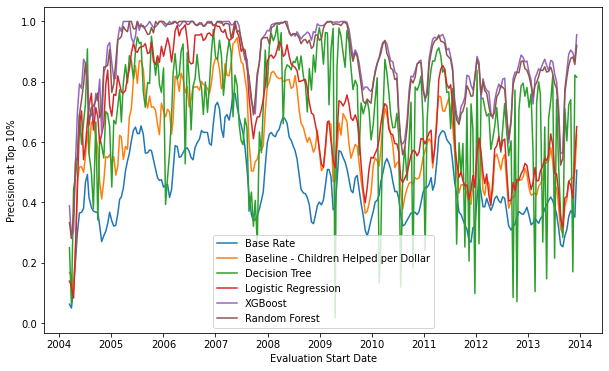

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
val_start_dates = []
for s in split:
  val_start_dates.append(s['val'][0])

rf_res = [0.33333333333333337, 0.28125, 0.36111111111111116, 0.5384615384615384, 0.55, 0.6896551724137931, 0.7407407407407407, 0.7916666666666666, 0.8620689655172413, 0.7878787878787878, 0.65625, 0.7142857142857143, 0.72, 0.7380952380952381, 0.7631578947368421, 0.6808510638297872, 0.7058823529411764, 0.8490566037735849, 0.8507462686567164, 0.8548387096774194, 0.9069767441860466, 0.7647058823529411, 0.7931034482758621, 0.8679245283018868, 0.94, 0.9433962264150944, 0.95, 0.9830508474576272, 0.9714285714285714, 0.9661016949152542, 1.0, 1.0, 0.9761904761904762, 0.975609756097561, 1.0, 0.9855072463768116, 0.9846153846153847, 0.9863013698630136, 0.9724770642201834, 0.9574468085106383, 0.9587628865979382, 0.9803921568627451, 0.9622641509433962, 1.0, 0.9904761904761905, 1.0, 1.0, 1.0, 0.9914529914529915, 0.990909090909091, 0.990909090909091, 0.9925373134328358, 0.9935897435897436, 1.0, 0.993421052631579, 1.0, 1.0, 1.0, 1.0, 0.9896907216494846, 0.9911504424778761, 1.0, 1.0, 0.990228013029316, 0.9859943977591037, 0.991869918699187, 0.9917355371900827, 0.9841897233201581, 0.989247311827957, 0.9962825278810409, 0.9945652173913043, 1.0, 0.9865771812080537, 0.9898477157360406, 1.0, 1.0, 1.0, 0.9856115107913669, 0.9933333333333333, 0.9933774834437086, 0.990990990990991, 0.9425287356321839, 0.968421052631579, 1.0, 0.9646017699115044, 0.9696969696969697, 0.9418604651162791, 0.9107981220657277, 0.8930041152263375, 0.8464730290456431, 0.8178913738019169, 0.7463556851311953, 0.6901408450704225, 0.7449324324324325, 0.8284518828451883, 0.8635547576301615, 0.9409448818897638, 0.9463519313304721, 0.9460043196544277, 0.947265625, 0.9253731343283582, 0.9799635701275046, 0.9834710743801653, 0.9920792079207921, 0.9956427015250545, 0.990632318501171, 0.9947229551451188, 0.9958677685950413, 1.0, 0.9834254143646409, 0.9663461538461539, 0.9528301886792453, 0.9595588235294118, 0.9592391304347826, 0.9560975609756097, 0.9458874458874459, 0.9263565891472868, 0.9381663113006397, 0.9403973509933775, 0.9277899343544858, 0.9381720430107527, 0.9105691056910569, 0.9177777777777778, 0.9548872180451128, 0.9552631578947368, 0.9376443418013857, 0.9423459244532804, 0.9776119402985075, 0.9935760171306209, 0.9977528089887641, 0.9979381443298969, 1.0, 0.9887640449438202, 0.9923954372623575, 0.9913793103448276, 0.9902676399026764, 0.9863013698630136, 0.9963636363636363, 0.9969604863221885, 0.9899497487437185, 0.9557926829268293, 0.90311004784689, 0.8680479825517994, 0.8971596474045054, 0.8827667057444314, 0.839171974522293, 0.7925636007827789, 0.7356828193832599, 0.7280701754385965, 0.7426778242677825, 0.7352380952380952, 0.7289719626168225, 0.8, 0.830820770519263, 0.8602150537634409, 0.877959927140255, 0.8933333333333333, 0.9237113402061856, 0.9372549019607843, 0.8944223107569721, 0.8790123456790123, 0.8449197860962567, 0.8402366863905325, 0.8073654390934845, 0.8115942028985508, 0.6825127334465195, 0.6072772898368883, 0.5575815738963532, 0.580046403712297, 0.6486880466472303, 0.7475409836065574, 0.8085106382978724, 0.7961165048543689, 0.815112540192926, 0.8592750533049041, 0.8641860465116279, 0.8639455782312925, 0.7722772277227723, 0.746309963099631, 0.7568093385214008, 0.8576555023923444, 0.897005988023952, 0.9214758751182592, 0.9352159468438538, 0.9409905163329821, 0.9553903345724907, 0.9345372460496614, 0.9327354260089686, 0.9276595744680851, 0.8893360160965795, 0.8814229249011858, 0.8751835535976505, 0.8357894736842105, 0.7160714285714286, 0.6741379310344828, 0.6587155963302752, 0.6943192064923354, 0.7026431718061674, 0.726790450928382, 0.7870485678704857, 0.7719298245614035, 0.7521008403361344, 0.7533333333333333, 0.8181049069373942, 0.8736167734420501, 0.8520859671302149, 0.7582417582417582, 0.8004410143329659, 0.7713382507903056, 0.7621212121212121, 0.7188081936685289, 0.6870503597122302, 0.6870370370370371, 0.698876404494382, 0.7494866529774127, 0.7627118644067796, 0.7868852459016393, 0.7820324005891016, 0.7744874715261959, 0.6915077989601386, 0.6091872791519435, 0.6747159090909092, 0.7910737386804657, 0.8140635564570655, 0.8318863456985004, 0.8299798792756539, 0.8673796791443851, 0.8694736842105263, 0.8435544430538173, 0.8385714285714285, 0.818287037037037, 0.7884028484231943, 0.7508690614136733, 0.788235294117647, 0.7977207977207977, 0.8177777777777777, 0.838810641627543, 0.8372093023255813, 0.8497023809523809, 0.8323442136498517, 0.8343465045592705, 0.8487394957983193, 0.8264781491002571, 0.7944025834230355, 0.7773343974461293, 0.6893203883495146, 0.5235204855842185, 0.5471014492753623, 0.7635679742074154, 0.8154435925520263, 0.8542795232936078, 0.8773109243697479, 0.8822684852835607, 0.8572815533980582, 0.9213973799126638]
lr_res = [0.13888888888888884, 0.125, 0.08333333333333337, 0.2564102564102564, 0.44999999999999996, 0.6551724137931034, 0.7037037037037037, 0.5416666666666667, 0.5862068965517242, 0.6666666666666667, 0.71875, 0.7619047619047619, 0.64, 0.7142857142857143, 0.6842105263157895, 0.5957446808510638, 0.6274509803921569, 0.6603773584905661, 0.791044776119403, 0.8387096774193549, 0.7209302325581395, 0.6862745098039216, 0.7586206896551724, 0.7547169811320755, 0.8200000000000001, 0.7924528301886793, 0.7666666666666666, 0.7627118644067796, 0.7714285714285715, 0.8135593220338984, 0.8409090909090909, 0.8947368421052632, 0.9285714285714286, 0.9024390243902439, 0.8974358974358975, 0.9130434782608696, 0.9153846153846154, 0.9178082191780822, 0.926605504587156, 0.8936170212765957, 0.8969072164948454, 0.9313725490196079, 0.8679245283018868, 0.8571428571428572, 0.8857142857142857, 0.8645833333333334, 0.9176470588235294, 0.8846153846153846, 0.9145299145299145, 0.9454545454545454, 0.9181818181818182, 0.8656716417910448, 0.9038461538461539, 0.96875, 0.9868421052631579, 0.952, 0.972972972972973, 0.9787234042553191, 0.9887640449438202, 0.9381443298969072, 0.8672566371681416, 0.859375, 0.8622754491017964, 0.9543973941368078, 0.9551820728291317, 0.9552845528455285, 0.9586776859504132, 0.9367588932806324, 0.942652329749104, 0.9591078066914498, 0.9619565217391304, 0.9536423841059603, 0.9530201342281879, 0.9898477157360406, 0.9834254143646409, 0.983402489626556, 0.967391304347826, 0.9640287769784173, 0.9733333333333334, 0.9470198675496688, 0.9369369369369369, 0.9425287356321839, 0.9473684210526316, 0.9888888888888889, 0.9646017699115044, 0.946969696969697, 0.9011627906976745, 0.9107981220657277, 0.9053497942386831, 0.8630705394190872, 0.7507987220447284, 0.6676384839650146, 0.6112676056338029, 0.6554054054054055, 0.6834030683403068, 0.6840215439856374, 0.7086614173228347, 0.740343347639485, 0.7883369330453563, 0.8671875, 0.8839137645107794, 0.8888888888888888, 0.878099173553719, 0.8871287128712871, 0.906318082788671, 0.9320843091334895, 0.920844327176781, 0.884297520661157, 0.8910891089108911, 0.9226519337016574, 0.8846153846153846, 0.8584905660377359, 0.8529411764705882, 0.8478260869565217, 0.8365853658536585, 0.8008658008658008, 0.8023255813953488, 0.8059701492537313, 0.8079470198675497, 0.7768052516411379, 0.7311827956989247, 0.6964769647696477, 0.6911111111111111, 0.6591478696741855, 0.6263157894736842, 0.5773672055427252, 0.5268389662027833, 0.5167910447761195, 0.582441113490364, 0.6674157303370787, 0.6701030927835052, 0.6047120418848168, 0.5393258426966292, 0.5152091254752852, 0.6241379310344828, 0.7372262773722628, 0.7328767123287672, 0.72, 0.7325227963525835, 0.7562814070351759, 0.7271341463414633, 0.680622009569378, 0.6717557251908397, 0.6904995102840352, 0.6694021101992966, 0.6194267515923566, 0.5264187866927593, 0.44273127753303965, 0.3991228070175439, 0.4497907949790795, 0.5123809523809524, 0.5495327102803738, 0.5467741935483871, 0.5628140703517588, 0.5770609318996416, 0.6102003642987249, 0.6571428571428571, 0.7010309278350515, 0.7274509803921569, 0.7191235059760956, 0.6444444444444444, 0.6283422459893049, 0.6242603550295858, 0.594900849858357, 0.5942028985507246, 0.5687606112054329, 0.4780426599749059, 0.4664107485604606, 0.47950502706883213, 0.4985422740524781, 0.5286885245901639, 0.5570599613152805, 0.5728155339805825, 0.5691318327974276, 0.5543710021321961, 0.5674418604651164, 0.6122448979591837, 0.6102610261026102, 0.5940959409594095, 0.6128404669260701, 0.631578947368421, 0.6395209580838324, 0.5316934720908231, 0.5772425249169435, 0.6628029504741834, 0.8085501858736059, 0.8419864559819413, 0.8542600896860987, 0.8425531914893617, 0.7927565392354124, 0.7786561264822134, 0.7900146842878121, 0.7231578947368421, 0.6053571428571429, 0.5327586206896552, 0.48348623853211015, 0.5013525698827772, 0.47246696035242286, 0.4549071618037135, 0.4582814445828145, 0.41019214703425233, 0.44201680672268906, 0.48888888888888893, 0.4500846023688664, 0.5655212580081538, 0.6137800252844501, 0.5684315684315684, 0.496141124586549, 0.46259220231822973, 0.4939393939393939, 0.4245810055865922, 0.3902877697841727, 0.4740740740740741, 0.5775280898876405, 0.5872689938398357, 0.6186440677966102, 0.5737704918032787, 0.6038291605301915, 0.6104783599088839, 0.5051993067590987, 0.4042402826855124, 0.40838068181818177, 0.46571798188874514, 0.4394861392832995, 0.4767166535122336, 0.47283702213279677, 0.4951871657754011, 0.5073684210526316, 0.5294117647058824, 0.5228571428571429, 0.47916666666666663, 0.4425228891149542, 0.4669756662804172, 0.5161764705882352, 0.47150997150997154, 0.47259259259259256, 0.5039123630672926, 0.5209302325581395, 0.5461309523809523, 0.5385756676557863, 0.5592705167173253, 0.6274509803921569, 0.589974293059126, 0.49730893433799783, 0.49481245011971264, 0.4356796116504854, 0.3449671219018715, 0.3188405797101449, 0.4148307361633531, 0.42004381161007665, 0.4712892741061755, 0.45658263305322133, 0.4134960516870064, 0.550485436893204, 0.6517467248908297]

decision_tree_res = [0.25, 0.0625, 0.4444444444444444, 0.4871794871794872, 0.55, 0.6896551724137931, 0.5925925925925926, 0.6666666666666667, 0.7241379310344828, 0.9090909090909091, 0.5625, 0.5, 0.38, 0.6666666666666667, 0.3421052631578947, 0.6170212765957447, 0.5882352941176471, 0.5471698113207547, 0.7014925373134329, 0.6935483870967742, 0.6511627906976745, 0.4509803921568627, 0.6724137931034483, 0.6603773584905661, 0.72, 0.7735849056603774, 0.6666666666666667, 0.7966101694915254, 0.8571428571428572, 0.7966101694915254, 0.8863636363636364, 0.868421052631579, 0.8095238095238095, 0.9024390243902439, 0.9487179487179487, 0.927536231884058, 0.9307692307692308, 0.7671232876712328, 0.7155963302752293, 0.7978723404255319, 0.7938144329896908, 0.9509803921568627, 0.8867924528301887, 0.8214285714285714, 0.8857142857142857, 0.7916666666666666, 0.7647058823529411, 0.8461538461538461, 0.3931623931623932, 0.4818181818181818, 0.5636363636363637, 0.6865671641791045, 0.8269230769230769, 0.89375, 0.8092105263157895, 0.8240000000000001, 0.9009009009009009, 0.925531914893617, 0.5280898876404494, 0.8969072164948454, 0.8141592920353982, 0.640625, 0.7844311377245509, 0.8110749185667753, 0.8907563025210083, 0.8089430894308943, 0.78099173553719, 0.691699604743083, 0.7992831541218638, 0.6988847583643123, 0.7934782608695652, 0.8940397350993378, 0.9731543624161074, 0.883248730964467, 0.8729281767955801, 0.9377593360995851, 0.8858695652173914, 0.7553956834532374, 0.8133333333333334, 0.8874172185430463, 0.9369369369369369, 0.896551724137931, 0.6842105263157895, 0.8222222222222222, 0.7876106194690266, 0.6590909090909092, 0.6046511627906976, 0.5915492957746479, 0.6790123456790124, 0.6473029045643153, 0.37060702875399365, 0.43440233236151604, 0.3211267605633803, 0.4070945945945946, 0.2635983263598326, 0.6337522441651706, 0.5649606299212598, 0.7167381974248928, 0.9049676025917927, 0.78125, 0.9187396351575456, 0.9599271402550091, 0.9359504132231405, 0.9544554455445544, 0.9869281045751634, 0.9039812646370023, 0.9630606860158312, 0.6611570247933884, 0.8366336633663366, 0.856353591160221, 0.8509615384615384, 0.839622641509434, 0.8676470588235294, 0.8641304347826086, 0.8829268292682927, 0.8398268398268398, 0.8856589147286822, 0.8166311300639659, 0.7902869757174393, 0.700218818380744, 0.8440860215053764, 0.7723577235772358, 0.8888888888888888, 0.8320802005012531, 0.9394736842105263, 0.9792147806004619, 0.9403578528827038, 0.8582089552238806, 0.9635974304068522, 0.9617977528089887, 0.7237113402061855, 0.9057591623036649, 0.9775280898876404, 0.017110266159695797, 0.8482758620689655, 0.9781021897810219, 0.952054794520548, 0.8945454545454545, 0.8480243161094225, 0.9698492462311558, 0.9314024390243902, 0.84688995215311, 0.7742639040348964, 0.8050930460333007, 0.7878077373974208, 0.5573248407643312, 0.7299412915851272, 0.6938325991189427, 0.7192982456140351, 0.7384937238493724, 0.7047619047619047, 0.6074766355140186, 0.6564516129032258, 0.7420435510887773, 0.8136200716845878, 0.13296903460837883, 0.2571428571428571, 0.6742268041237114, 0.8745098039215686, 0.8286852589641435, 0.7679012345679013, 0.6898395721925134, 0.6479289940828402, 0.6487252124645893, 0.6956521739130435, 0.6213921901528013, 0.11919698870765372, 0.49424184261036463, 0.5846867749419953, 0.4737609329446064, 0.6065573770491803, 0.7321083172147003, 0.183252427184466, 0.7829581993569132, 0.7718550106609808, 0.7897674418604651, 0.8182701652089407, 0.6804680468046804, 0.2407749077490775, 0.6731517509727627, 0.7858851674641149, 0.8419161676646707, 0.869441816461684, 0.8687707641196013, 0.9009483667017913, 0.912639405204461, 0.8848758465011287, 0.8318385650224215, 0.8425531914893617, 0.7645875251509054, 0.766798418972332, 0.644640234948605, 0.7778947368421052, 0.6866071428571429, 0.26206896551724135, 0.5981651376146788, 0.49774571686203783, 0.5958149779735683, 0.2519893899204244, 0.7135740971357409, 0.20551378446115287, 0.7268907563025211, 0.6422222222222222, 0.09813874788494081, 0.8380896913220734, 0.2629582806573957, 0.7462537462537462, 0.7453142227122381, 0.714436248682824, 0.6863636363636363, 0.6945996275605214, 0.5755395683453237, 0.6129629629629629, 0.651685393258427, 0.7145790554414784, 0.6228813559322034, 0.5664845173041895, 0.6450662739322532, 0.7277904328018223, 0.6351819757365684, 0.5547703180212014, 0.6044034090909092, 0.0847347994825356, 0.7728194726166329, 0.07103393843725336, 0.7082494969818913, 0.786096256684492, 0.7957894736842105, 0.7521902377972466, 0.7814285714285714, 0.7152777777777778, 0.7599186164801628, 0.5643105446118193, 0.10441176470588232, 0.7321937321937322, 0.8, 0.7605633802816901, 0.2682170542635659, 0.6502976190476191, 0.14688427299703266, 0.6778115501519757, 0.7380952380952381, 0.8200514138817481, 0.2152852529601722, 0.7414205905826017, 0.5254854368932038, 0.3621648963075367, 0.28364389233954457, 0.7109081139172488, 0.604052573932092, 0.7237269772481041, 0.7406162464985995, 0.17013639626704957, 0.8223300970873786, 0.8155021834061136]
xgb_res = [0.38888888888888884, 0.28125, 0.3055555555555556, 0.5384615384615384, 0.7, 0.7931034482758621, 0.7777777777777778, 0.875, 0.8620689655172413, 0.8181818181818181, 0.71875, 0.6904761904761905, 0.6799999999999999, 0.7619047619047619, 0.736842105263158, 0.8085106382978724, 0.6274509803921569, 0.8301886792452831, 0.8507462686567164, 0.9193548387096774, 0.9302325581395349, 0.8627450980392157, 0.8103448275862069, 0.8113207547169812, 0.94, 0.9811320754716981, 0.9666666666666667, 1.0, 1.0, 1.0, 1.0, 0.9473684210526316, 0.9285714285714286, 0.9512195121951219, 1.0, 0.9710144927536232, 0.9923076923076923, 0.9794520547945206, 0.981651376146789, 0.9893617021276596, 1.0, 0.9901960784313726, 0.9811320754716981, 0.9821428571428571, 0.9904761904761905, 1.0, 1.0, 0.9903846153846154, 0.9829059829059829, 0.990909090909091, 1.0, 0.9925373134328358, 1.0, 1.0, 0.993421052631579, 0.984, 0.990990990990991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.990228013029316, 0.988795518207283, 0.9959349593495935, 0.9958677685950413, 0.9841897233201581, 0.985663082437276, 1.0, 1.0, 0.9933774834437086, 0.9865771812080537, 0.9898477157360406, 1.0, 0.995850622406639, 0.9945652173913043, 1.0, 1.0, 1.0, 1.0, 0.9885057471264368, 0.9894736842105263, 1.0, 1.0, 0.9848484848484849, 0.936046511627907, 0.9061032863849765, 0.8724279835390947, 0.8755186721991701, 0.8019169329073482, 0.7346938775510203, 0.7098591549295774, 0.6942567567567568, 0.8131101813110182, 0.8653500897666069, 0.9389763779527559, 0.9484978540772532, 0.9568034557235421, 0.970703125, 0.9684908789386402, 0.9890710382513661, 0.9917355371900827, 0.994059405940594, 0.9912854030501089, 0.9953161592505855, 0.9973614775725593, 0.9958677685950413, 1.0, 1.0, 0.9615384615384616, 0.9528301886792453, 0.9595588235294118, 0.9510869565217391, 0.9658536585365853, 0.9545454545454546, 0.9418604651162791, 0.9530916844349681, 0.9580573951434879, 0.9649890590809628, 0.9596774193548387, 0.9376693766937669, 0.9666666666666667, 0.9624060150375939, 0.9921052631578947, 0.9861431870669746, 0.9860834990059643, 0.9869402985074627, 0.9914346895074947, 1.0, 1.0, 1.0, 0.9971910112359551, 0.9980988593155894, 0.9982758620689656, 0.9975669099756691, 1.0, 1.0, 1.0, 0.9974874371859297, 0.975609756097561, 0.930622009569378, 0.88113413304253, 0.9059745347698335, 0.8921453692848769, 0.8630573248407644, 0.8180039138943249, 0.7731277533039648, 0.7828947368421053, 0.7824267782426778, 0.7733333333333333, 0.7682242990654206, 0.7870967741935484, 0.8375209380234506, 0.8620071684587813, 0.8816029143897997, 0.9066666666666666, 0.9298969072164949, 0.9352941176470588, 0.9262948207171314, 0.8962962962962963, 0.8689839572192514, 0.8668639053254438, 0.8328611898016998, 0.8260869565217391, 0.701188455008489, 0.6022584692597239, 0.5940499040307101, 0.6063418406805878, 0.6756559766763848, 0.7729508196721311, 0.8191489361702128, 0.8155339805825242, 0.8360128617363344, 0.8582089552238806, 0.867906976744186, 0.8717201166180758, 0.7884788478847885, 0.7343173431734318, 0.7782101167315175, 0.8755980861244019, 0.9149700598802395, 0.9413434247871334, 0.9476744186046512, 0.9430979978925185, 0.9479553903345725, 0.9525959367945824, 0.9573991031390134, 0.9404255319148936, 0.9054325955734407, 0.9110671936758893, 0.8839941262848752, 0.8463157894736842, 0.7428571428571429, 0.6913793103448276, 0.6669724770642202, 0.7177637511271415, 0.7290748898678414, 0.7493368700265253, 0.821917808219178, 0.8178780284043442, 0.788235294117647, 0.7733333333333333, 0.8087986463620982, 0.8841001747233547, 0.8647281921618205, 0.7432567432567432, 0.8103638368246968, 0.78609062170706, 0.7712121212121212, 0.7672253258845437, 0.697841726618705, 0.6777777777777778, 0.7370786516853933, 0.7700205338809035, 0.7923728813559322, 0.7795992714025501, 0.8085419734904271, 0.8120728929384966, 0.6889081455805892, 0.5964664310954064, 0.6669034090909092, 0.8104786545924968, 0.8316430020283976, 0.8326756116811366, 0.8591549295774648, 0.8887700534759359, 0.8810526315789473, 0.8660826032540676, 0.8685714285714285, 0.8298611111111112, 0.8056968463886063, 0.7265353418308227, 0.8117647058823529, 0.8247863247863247, 0.8429629629629629, 0.838810641627543, 0.8604651162790697, 0.875, 0.8545994065281899, 0.837386018237082, 0.8711484593837535, 0.8663239074550129, 0.8277717976318621, 0.8004788507581804, 0.7160194174757282, 0.5629742033383915, 0.5652173913043479, 0.7764642665233745, 0.8357064622124863, 0.8916576381365113, 0.9053221288515406, 0.8959081119885139, 0.870873786407767, 0.9563318777292577]

base_rate = [0.06284153005464477, 0.050000000000000044, 0.1202185792349727, 0.2102564102564103, 0.30147058823529416, 0.3648648648648649, 0.36764705882352944, 0.3801652892561983, 0.4664429530201343, 0.4925373134328358, 0.4171779141104295, 0.3835294117647059, 0.37125748502994016, 0.3681710213776722, 0.36623376623376624, 0.32278481012658233, 0.2704280155642024, 0.2900188323917138, 0.3046062407132244, 0.32961783439490444, 0.36757990867579904, 0.33852140077821014, 0.3214285714285714, 0.32457786116322707, 0.362, 0.4101123595505618, 0.41860465116279066, 0.44741235392320533, 0.5049645390070923, 0.5375626043405677, 0.5627802690582959, 0.6036745406824147, 0.639344262295082, 0.6498800959232613, 0.628498727735369, 0.6280752532561504, 0.6539343009931244, 0.6255989048596852, 0.5642201834862386, 0.5642933049946866, 0.5740551583248212, 0.5719882468168462, 0.5417057169634489, 0.5106571936056838, 0.4815864022662889, 0.472972972972973, 0.47540983606557374, 0.45052833813640725, 0.4568744662681469, 0.4602169981916817, 0.4169675090252708, 0.4422073079791201, 0.5047862156987875, 0.5882719900187149, 0.5853018372703411, 0.5494417862838916, 0.5526552655265526, 0.5650793650793651, 0.5795964125560538, 0.5806783144912642, 0.5702987697715289, 0.5487900078064012, 0.5413936867182847, 0.5823319259499837, 0.5973154362416108, 0.6103685702713649, 0.6384647131654972, 0.632242806464328, 0.6325581395348837, 0.6314031180400891, 0.595018949648078, 0.5898282694848085, 0.6622073578595318, 0.7218007081436519, 0.7318281938325991, 0.7103734439834024, 0.6429734129137277, 0.6161035226455787, 0.682571239231279, 0.6912928759894459, 0.6729559748427674, 0.7095671981776766, 0.759958071278826, 0.7619047619047619, 0.716931216931217, 0.6825037707390649, 0.6566125290023201, 0.6302010285179991, 0.582340862422998, 0.5113777410012412, 0.426475279106858, 0.3594523740168949, 0.339521800281294, 0.3426113360323887, 0.35577861424787394, 0.3789209535759097, 0.40625, 0.4346706715297146, 0.5214578391201208, 0.5968402574605032, 0.6267395626242545, 0.6319810805894124, 0.6218782249742002, 0.6178974460502871, 0.633413199738619, 0.6418050035071312, 0.6673700870482722, 0.6829971181556196, 0.6765578635014837, 0.6628099173553719, 0.6163793103448276, 0.6060178655383168, 0.586852735952993, 0.5722826086956522, 0.5439024390243903, 0.4931891891891892, 0.4437342630253729, 0.4311555650138327, 0.42907566732848, 0.4158653846153846, 0.39259855189058734, 0.3353196099674973, 0.32978487469505435, 0.35529942370333245, 0.38853838065194535, 0.4013370216689719, 0.3921334922526818, 0.40869240813281105, 0.4572284003421728, 0.5092093441150045, 0.5094689172498971, 0.4856171548117155, 0.37573715248525696, 0.3835043709616116, 0.46682750301568154, 0.5719834911386259, 0.5677618069815196, 0.5488203266787659, 0.5340425531914894, 0.5111612741409581, 0.477141115513563, 0.4398613103778096, 0.43216737495913693, 0.4815974941268598, 0.4895711272556832, 0.44348933460681317, 0.39765395894428157, 0.35723713154421466, 0.30863656291100394, 0.28828451882845185, 0.3132140137090632, 0.3427878335510356, 0.3692605123247946, 0.401707970529136, 0.4068100358422939, 0.42550482081135166, 0.4688630737002476, 0.49577754891864056, 0.5310358331701586, 0.5453821656050956, 0.5305719921104537, 0.509076348104645, 0.47086660751257026, 0.4359988697372139, 0.4368065605402798, 0.41341256366723256, 0.3599448552450182, 0.32217533090351047, 0.3266836774143663, 0.34146696773253693, 0.3536545394952475, 0.36476162846920024, 0.3646844660194175, 0.36752411575562705, 0.3594799104763935, 0.3705494096867157, 0.3991257892180671, 0.43314738168076306, 0.4497740060879992, 0.4497179537055047, 0.4605090213884574, 0.48258944597343545, 0.4408398751536934, 0.46200481687567474, 0.5350258084904667, 0.6174832962138085, 0.6309148264984228, 0.6377493835462901, 0.6324968098681412, 0.6085209003215435, 0.5987751876728566, 0.5906956266510126, 0.5330526315789474, 0.4678153736273547, 0.4254329284052727, 0.36769696413831054, 0.36004687640854593, 0.3427974028832398, 0.32533156498673743, 0.3112714605623289, 0.27316013699774455, 0.26879462410751787, 0.31626305265496557, 0.31980382208692715, 0.4145602795573675, 0.4760851709104694, 0.42995506739890166, 0.3858102897433072, 0.3853201347935973, 0.41359987884295013, 0.391886862672125, 0.37374100719424463, 0.3892381656804734, 0.41307277628032346, 0.4212792127921279, 0.40537679932260795, 0.39857975236707943, 0.41881348446930666, 0.41340464269458355, 0.36903628019741974, 0.3217489581125945, 0.3085604770017035, 0.3208511188720735, 0.32709332972899907, 0.35341903935641616, 0.37008349260637763, 0.36351004702864476, 0.36038311756657193, 0.3695407333249906, 0.3840879874303671, 0.3561596298438404, 0.3256381572256687, 0.33221398795738766, 0.3483179080358455, 0.3395931142410016, 0.3308660251665433, 0.3452101890920456, 0.3579290032553093, 0.3793513835168105, 0.3932650941996736, 0.4064966605950212, 0.417973124300112, 0.4054713588492166, 0.3863293864370291, 0.36133046183297435, 0.3159458967671499, 0.26028020838601995, 0.25302763689059105, 0.28941429339065017, 0.31010128661374214, 0.3534095217461951, 0.3727522267660075, 0.3621679827709978, 0.351445759751601, 0.5067670814232701]
baseline_results = [0.16666666666666663, 0.15625, 0.11111111111111116, 0.2564102564102564, 0.475, 0.5172413793103448, 0.5185185185185186, 0.5, 0.5517241379310345, 0.6363636363636364, 0.5625, 0.6666666666666667, 0.6599999999999999, 0.6190476190476191, 0.5789473684210527, 0.46808510638297873, 0.4117647058823529, 0.4716981132075472, 0.5522388059701493, 0.5483870967741935, 0.5581395348837209, 0.5294117647058824, 0.5517241379310345, 0.49056603773584906, 0.52, 0.6226415094339622, 0.6166666666666667, 0.5423728813559322, 0.5857142857142856, 0.576271186440678, 0.6818181818181819, 0.7105263157894737, 0.8095238095238095, 0.8536585365853658, 0.7948717948717949, 0.8695652173913043, 0.8692307692307693, 0.8424657534246576, 0.7522935779816513, 0.7127659574468085, 0.7525773195876289, 0.7156862745098039, 0.7169811320754718, 0.7053571428571428, 0.6571428571428571, 0.625, 0.7294117647058824, 0.7019230769230769, 0.6837606837606838, 0.7090909090909091, 0.7, 0.6268656716417911, 0.6730769230769231, 0.81875, 0.8092105263157895, 0.768, 0.8288288288288288, 0.8085106382978724, 0.7640449438202247, 0.7835051546391752, 0.7168141592920354, 0.7421875, 0.7844311377245509, 0.7817589576547231, 0.7843137254901961, 0.7723577235772358, 0.8016528925619835, 0.7905138339920948, 0.7885304659498208, 0.7769516728624535, 0.7608695652173914, 0.794701986754967, 0.8523489932885906, 0.8781725888324873, 0.8784530386740331, 0.8423236514522822, 0.7771739130434783, 0.7913669064748201, 0.86, 0.8211920529801324, 0.8198198198198199, 0.8620689655172413, 0.9263157894736842, 0.9333333333333333, 0.9469026548672567, 0.9015151515151515, 0.8662790697674418, 0.8591549295774648, 0.8106995884773662, 0.7676348547717842, 0.6038338658146964, 0.5043731778425655, 0.504225352112676, 0.535472972972973, 0.5425383542538355, 0.5745062836624776, 0.5728346456692913, 0.5879828326180258, 0.6997840172786177, 0.783203125, 0.8009950248756219, 0.8306010928961749, 0.8347107438016529, 0.8237623762376238, 0.8148148148148149, 0.810304449648712, 0.8126649076517151, 0.8016528925619835, 0.801980198019802, 0.8066298342541436, 0.8076923076923077, 0.7783018867924528, 0.7830882352941176, 0.8206521739130435, 0.775609756097561, 0.7099567099567099, 0.6627906976744187, 0.6481876332622601, 0.620309050772627, 0.5995623632385121, 0.6155913978494624, 0.5934959349593496, 0.5666666666666667, 0.581453634085213, 0.6394736842105263, 0.5727482678983833, 0.5049701789264414, 0.5167910447761195, 0.582441113490364, 0.6584269662921348, 0.6639175257731958, 0.6596858638743455, 0.4691011235955056, 0.47148288973384034, 0.5758620689655172, 0.6642335766423357, 0.6232876712328768, 0.6945454545454546, 0.6808510638297872, 0.6683417085427136, 0.5945121951219512, 0.5466507177033493, 0.5681570338058888, 0.5925563173359452, 0.5849941383352872, 0.5318471337579618, 0.4735812133072407, 0.4251101321585903, 0.36403508771929827, 0.37029288702928875, 0.3961904761904762, 0.4317757009345794, 0.5209677419354839, 0.5477386934673367, 0.5376344086021505, 0.5209471766848817, 0.5752380952380952, 0.6556701030927835, 0.711764705882353, 0.6892430278884463, 0.6567901234567901, 0.625668449197861, 0.591715976331361, 0.5155807365439093, 0.5314009661835748, 0.534804753820034, 0.43914680050188204, 0.37811900191938574, 0.4168600154679041, 0.44752186588921283, 0.4639344262295082, 0.4671179883945842, 0.46116504854368934, 0.4823151125401929, 0.4776119402985075, 0.4818604651162791, 0.5072886297376094, 0.5481548154815481, 0.5710332103321033, 0.5963035019455253, 0.611244019138756, 0.6, 0.5146641438032167, 0.5772425249169435, 0.6859852476290833, 0.7527881040892194, 0.7494356659142212, 0.7040358744394619, 0.7021276595744681, 0.7243460764587526, 0.7450592885375493, 0.7019089574155654, 0.6568421052631579, 0.5678571428571428, 0.4948275862068966, 0.4311926605504587, 0.45807033363390437, 0.45925110132158586, 0.4456233421750663, 0.4296388542963886, 0.39766081871345027, 0.3941176470588236, 0.4622222222222222, 0.4653130287648054, 0.5544554455445545, 0.5979772439949431, 0.5424575424575424, 0.4399117971334069, 0.4236037934668072, 0.4757575757575757, 0.46368715083798884, 0.4118705035971223, 0.44074074074074077, 0.548314606741573, 0.5605749486652978, 0.5360169491525424, 0.5081967213114754, 0.5434462444771724, 0.5592255125284737, 0.4653379549393414, 0.3809187279151943, 0.40625, 0.42043984476067275, 0.41987829614604466, 0.46172059984214675, 0.4768611670020121, 0.47379679144385023, 0.4831578947368421, 0.5131414267834793, 0.4928571428571429, 0.4467592592592593, 0.42421159715157686, 0.42757821552723063, 0.4308823529411765, 0.4245014245014245, 0.45333333333333337, 0.4616588419405321, 0.48062015503875966, 0.5252976190476191, 0.5326409495548962, 0.5364741641337386, 0.5812324929971988, 0.5347043701799485, 0.4531754574811625, 0.4493216280925778, 0.38652912621359226, 0.3125948406676783, 0.2960662525879917, 0.3879634605051048, 0.41018619934282585, 0.4669555796316359, 0.4784313725490196, 0.4816941852117731, 0.5, 0.6244541484716157]

ax.plot(val_start_dates, base_rate, label='Base Rate')
ax.plot(val_start_dates, baseline_results, label='Baseline - Children Helped per Dollar')
ax.plot(val_start_dates, decision_tree_res, label='Decision Tree')
ax.plot(val_start_dates, lr_res, label='Logistic Regression')
ax.plot(val_start_dates, xgb_res, label='XGBoost')
ax.plot(val_start_dates, rf_res, label='Random Forest')
ax.legend()

ax.set_xlabel('Evaluation Start Date')
ax.set_ylabel('Precision at Top 10%')